# Description
This is a trace based simulator used in some initial verifications of the paper: 'Adaptive TTL-based Caching for Content Delivery' by S. Basu et al [1]. Please refer to the aforementioned paper while using this code or modifications thereof. 

The original paper uses an optimized code to facilitate scaling of the code to large scale traces. However, this simulator is able to handle traces of size (number of requests) upto a few million on a standard MAC laptop (Memory: 8 GB 1867 MHz DDR3, Processor: 2.7 GHz Intel Core i5) with each object as a string of 5 chars. Note that the objects cached should not consume large memory, otherwise it may cause memory overflow. Furthermore, caching large object body is irrelevant for testing the accuracy of the proposed algorithms. 


**References**

[1] Basu, Soumya, Aditya Sundarrajan, Javad Ghaderi, Sanjay Shakkottai, and Ramesh Sitaraman. "Adaptive TTL-based caching for content delivery." IEEE/ACM Transactions on Networking (2018).

# Code

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict  as OD
import math
from time import time
from time import sleep
from threading import RLock
try:
    from collections import OrderedDict
except ImportError:
    # Python < 2.7
    from ordereddict import OrderedDict
from matplotlib import pyplot as plt
import string
import random
from scipy.linalg import eig

### Auxiliary functions

In [2]:
truncate = lambda x: np.minimum(1, np.maximum(0,x))

def list_sum(A,B):
    # sums two lists 'A' and 'B'
    return [(x+y) for (x,y) in zip(A, B)]


def moving_average_uw(a, n=3) :
    # moving average of the array 'a' with a window size 'n'
    # unweighted entries
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:]/n

def cum_average_uw(a):
    # cumulative average of the array 'a'
    # unweighted entries
    count = range(1, len(a)+1)
    cumsum = np.cumsum(a)
    return np.divide(cumsum, count, dtype = float)


def moving_average(a, n=3, wghts = None) :
    # moving average of the array 'a' with a window size 'n'
    # weighted entries with weights 'wghts'
    if wghts is None:
        wghts = np.ones(len(a))
    ret = np.cumsum(np.multiply(a, wghts), dtype=float)
    w_ret = np.cumsum(wghts, dtype = float)
    ret[n:] = ret[n:] - ret[:-n]
    w_ret[n:] = w_ret[n:] - w_ret[:-n]
    return np.divide(ret[n - 1:], w_ret[n - 1:], dtype = float)

def cum_average(a, wghts = None):
    # cumulative average of the array 'a'
    # weighted entries with weights 'wghts'
    if wghts is None:
        wghts = np.ones(len(a))
    w_count = np.cumsum(wghts)
    cumsum = np.cumsum(np.multiply(a, wghts)).astype(float) 
    return np.divide(cumsum, w_count)

def rand_string(X):
    # generates a random string with 'X' chars
    return ''.join(random.sample(string.ascii_lowercase, X))

## Classes of TTL Cache

### 1. TTL Cache

In [3]:
'''
TTL Cache with auto-expiring values for caching purposes.

Expiration happens when the method 'contains' and 'getitem' are called internally. 

This part of the code has some elements in common with the ExpiringDict source code.
See: pypi.org/project/expiringdict/
'''
class TTL_Cache:
    def __init__(self, max_len, max_age_seconds):
        assert max_age_seconds >= 0
        assert max_len >= 1

        self.cache = OrderedDict()  # the cache 
        self.max_len = max_len # maximum length of the cache
        self.max_age = max_age_seconds # maximum value of ttl
        self.lock = RLock()

    def __contains__(self, pair, with_ttl_rem = False):
        """
        pair = (query_time, key): 'key' is queried at 'query_time'
        with_ttl_rem = True: Returns the 'remaining ttl' of 'key'
        - Return True if the cache has a 'key' at 'query_time', else return False
        """
        query_time, key = pair
        try:
            with self.lock:
                item = self.cache[key]
                ins_time = item[1]
                item_age = query_time - ins_time
                item_ttl = min(self.max_age, item[2])
                item_rem = (item_ttl - item_age)
                
                if item_rem > 0:
                    if with_ttl_rem:
                        return True, item_rem
                    else:
                        return True
                else:
                    del self.cache[key]
        except KeyError:
            pass
        if with_ttl_rem:
            return False, 0
        else:
            return False

    def __getitem__(self, pair, with_info = False):
        """ 
        pair = (query_time, key): 'key' is queried at 'query_time'
        with_info = True: Returns 'item age' and 'remaining ttl', alongside 'item'
        - Returns 'item' (associated with 'key') if the cache has 'key' at 'query_time'
        - Raises a KeyError if key is not in the map.
        """
        access_time, key = pair
        
        with self.lock:
            item = self.cache[key]
            ins_time = item[1]
            item_age = (access_time - ins_time)
            item_ttl = min(self.max_age, item[2])
            item_rem = (item_ttl - item_age)
            if item_rem > 0:
                if with_info:
                    return item[0], (item_age, item_rem)
                else:
                    return item[0]
            else:
                del self.cache[key]
                raise KeyError(key)

    def __setitem__(self, pair, value):
        """ 
        pair = (insertion time, key)
        value = (key_obj, ins_time, item_ttl)
            key_obj: body corresponding to 'key'
            ins_time: insertion time 
            item_ttl: ttl value at insertion time
        - Inserts 'key' in the cache with item_ttl
        """
        ins_time, key = pair
        key_obj, item_ttl = value
        with self.lock:
            if len(self.cache) == self.max_len:
                self.freespace(time)
            self.cache[key] = (key_obj, ins_time, item_ttl)
    
    def delete_key(self, key):
        """
        - deleted 'key' from cache
        """
        with self.lock:
            try:
                del self.cache[key]
            except:
                pass

    def freespace(self, time):
        """ 
        -Frees the least recently used item if cache is full at time 
        (Note: Needs improvement as it requires a full scan now)
        """
        for key in self.cache:
            self.__contains__((time, key))
        with self.lock:
            if len(self.cache) == self.max_len:
                self.cache.popitem(last = False)
                
    def ttl(self, time, key):
        """ 
        - Return remaming ttl of the 'key' (in seconds) at time 
        - Returns None for non-existent or expired keys.
        """
        try:
            item = self.__getitem__((time,key), with_info = True)
            return item[1][0]
        except:
            return None

    def keys(self, time):
        """
        - Returns keys at time 
        """
        r = []
        for key in self.cache:
            try:
                item = self.cache[key]
                item_age = time - item[1]
                item_rem = item[2] - item_age
                if self.__contains__((time, key)):
                        r.append(key)
            except KeyError:
                pass
        return r

    def values(self, time, with_info = False):
        """ 
        - Returns list of values at time, 
        with information if with_info is True
        """
        r = []
        for key in self.cache:
            try:
                item = self.cache[key]
                item_age = time - item[1]
                item_rem = item[2] - item_age
                if self.__contains__((time, key)):
                    if with_info:
                        r.append((item[0], item_age, item_rem))
                    else:
                        r.append(item[0])
            except KeyError:
                pass
        return r
    
    def items(self, time, with_info = False):
        """ 
        - Returns list of items, i.e. (key, value) pairs at time, 
        with information if with_info is True
        """
        keys = self.keys(time)
        values = self.values(time, with_info)
        return zip(keys, values)
    
    def size(self, time, func_size):
        """
        - Returns total size of the cache at time
        """
        return np.sum([func_size(k) for k in self.keys(time)])
    
    def num_elements(self, time):
        """
        - Returns number of elements in the cache at time
        """
        return len(self.values(time))

    def display(self, time, with_info = False):
        """
        - Displays items in cache at time 
        """
        print 'Display time:%.2f'%time
        ix = self.items(time, with_info)
        if with_info:
            print 'Cache: (key, (object , item_age, ttl_rem)) :'
            print [(x[0], (x[1][0], format(x[1][1], '.3f'), format(x[1][2], '.3f')))  for x in ix]
        else: 
            print 'Cache: (key, object) :'
            print ix
        print '------------'

### 2. dTTL Cache

In [4]:
# dTTL implementation for a single class
class dTTL:

    def __init__(self, param_algo):
        self.max_size = param_algo['max_size']
        self.max_age = param_algo['max_age']
        self.hit_target = param_algo['hit_target']
        self.bhit_target = param_algo['bhit_target']
        #-----key-item functions----
        self.func = param_algo['func'] # funciton to return body of key
        self.return_size = param_algo['return_size'] # function to return size of key
        self.return_type = param_algo['return_type'] # function to return type of key
        #-----ttl-----
        self.vttl_value = param_algo['vttl_init'][0]
        self.alpha = param_algo['alpha'][0]
        self.step_const = param_algo['step_const'][0]
        self.num_type = len(self.vttl_value)
        #-----internal log----
        self.curr_time = -1e-3;
        self.bytesec = [0]*self.num_type; self.req = [0]*self.num_type; 
        self.hit = [0]*self.num_type; self.bhit = [0]*self.num_type;
        self.breq = [0]*self.num_type; self.ttl_avg = [0]*self.num_type;
        
        #***cache instantiation***
        self.cache = TTL_Cache(max_len = self.max_size, max_age_seconds = max(self.max_age))
    
    def get_ttl(self):
        """ gets the current ttl value """
        return np.multiply(self.vttl_value, self.max_age)
        
    def __call__(self, pair, ix):
        """
        pair = (time , key)
        ix: denotes the ix-th request
        - Item 'key' is requested at 'time' as the 'ix'-th request
        - Returns: hit and ttl value
        """
        func = self.func
        time, key = pair
        w = self.return_size(key) #size
        t = int(self.return_type(key)) #type
        
        # check if valid entry
        if time < self.curr_time:
            print 'Ignoring as past time referenced'
            return [None, None]
        else:
            self.curr_time = time
            self.req[t] += 1
            self.breq[t] += w

        # check for hit
        hit, ttl_rem = self.cache.__contains__(pair, True)
        ttl = self.get_ttl()
        
        # update cache
        self.cache[pair] = (func(key), ttl[t])
        
        
        #update vttl value
        step_size = self.step_const/(ix**self.alpha)
        if self.hit_target is None:
            # byte hit rate
            self.vttl_value[t] = truncate(self.vttl_value[t] - w*step_size*(hit-self.bhit_target[t]))
        else:
            # object hit rate
            self.vttl_value[t] = truncate(self.vttl_value[t] - step_size*(hit-self.hit_target[t]))
        
        # logging
        self.ttl_avg[t] = ((self.req[t]-1)*self.ttl_avg[t] + ttl[t])/float(self.req[t])
        self.bytesec[t] += w*(ttl[t]-ttl_rem)
        self.hit[t] += hit
        self.bhit[t] += w*hit
        
        return [hit, self.get_ttl()]
    
    def display(self, time, with_info = False):
        """
        - Displays the cache
        """
        np.set_printoptions(precision=3)
        print 'vTTL_value:%s'%" ".join("%.2f" % x for x in self.vttl_value)
        print 'TTL_value:%s'%" ".join("%.2f" % x for x in self.get_ttl())
        self.cache.display(time, with_info)
        
    def get_ttl_avg(self):
        """
        - gets the average ttl upto current time
        """
        return self.ttl_avg
    
    def hit_rate_avg(self):
        """
        - gets the average  object hit rate upto current time
        """
        np.set_printoptions(precision=3)
        print '# requests:%s'%" ".join("%.2f" % x for x in self.req)
        print '# hits:%s'%" ".join("%.2f" % x for x in self.hit)
        return np.divide(self.hit, self.req, dtype = float)
    
    def bhit_rate_avg(self):
        """
        - gets the average byte hit rate upto current time
        """
        print 'requests in bytes:%s'%" ".join("%.2f" % x for x in self.breq)
        print 'hits in bytes:%s'%" ".join("%.2f" % x for x in self.bhit)
        return np.divide(self.bhit, self.breq, dtype = float)
    
    def size_avg(self):
        '''
        - gets the average cache size upto current time
        (Warning: For small self.curr_time ( O(10*actual size_avg)) 
        this evaluation may not be accurate. 
        We need to substract the remaining ttl of all the elements in the cache at 
        self.curr_time from self.bytesec for an accurate implementation.)
        '''
        print 'total bytesec:%s'%" ".join("%.2f" % x for x in self.bytesec)
        print 'total time:%.2f'%self.curr_time
        res = np.divide(self.bytesec, self.curr_time, dtype = float)
        return res

## 3. fTTL Cache

In [5]:
class fTTL:
    def __init__(self,param_algo):
        self.max_size = param_algo['max_size']
        self.max_age = param_algo['max_age']
        self.hit_target = param_algo['hit_target']
        self.bhit_target = param_algo['bhit_target']
        self.sr_target = param_algo['sr_target']
        #-----
        self.func = param_algo['func']# funciton to return body of key
        self.return_size = param_algo['return_size']# funciton to return size of key
        self.return_type = param_algo['return_type']# funciton to return type of key
        #----
        self.vttl_value = param_algo['vttl_init']
        self.alpha = param_algo['alpha']
        self.eps = param_algo['eps'] # used in threshold function
        self.step_const = param_algo['step_const']
        self.num_type = np.shape(self.vttl_value)[1]
        # internal log
        self.curr_time = -1e-3; 
        self.req = [0]*self.num_type; self.breq = [0]*self.num_type;
        self.hit_primary = [0]*self.num_type; self.hit_shallow = [0]*self.num_type; 
        self.hit_shadow = [0]*self.num_type
        self.bhit_primary = [0]*self.num_type; self.bhit_shallow = [0]*self.num_type; 
        self.bhit_shadow = [0]*self.num_type
        self.bsec_primary = [0]*self.num_type; self.bsec_shallow = [0]*self.num_type; 
        self.bsec_shadow = [0]*self.num_type
        self.ttl_avg = [0]*self.num_type; self.ttl_shallow_avg = [0]*self.num_type;
        # cache instantiation
        self.primary = TTL_Cache(max_len = self.max_size, max_age_seconds = max(self.max_age))
        self.shallow = TTL_Cache(max_len = self.max_size, max_age_seconds = max(self.max_age))
        self.shadow = TTL_Cache(max_len = self.max_size, max_age_seconds = max(self.max_age))
    
    def get_ttl(self):
        """ gets the current ttl value (uses threshold function)"""
        x = self.vttl_value[0] 
        y = self.vttl_value[1]
        a = (np.maximum(0, x - 1.0 + 1.5*self.eps))**4
        b = (np.maximum(0, 1.0 - x - 0.5*self.eps))**4
        L = self.max_age
        ttl = np.multiply(L, x)
        ttl_shallow = np.multiply(np.multiply(L, x), y + np.divide(np.multiply((1-y),a),(a+b)))
        return (ttl, ttl_shallow)
    
    def get_ttl_alt(self):
        """ gets the current ttl value (does not use the threshold function)"""
        ttl = np.multiply(self.vttl_value[0], self.max_age) 
        ttl_shallow = np.multiply(self.vttl_value[1], self.max_age) 
        return ttl, ttl_shallow
    
    def __call__(self, pair, ix):
        """
        pair = (time , key)
        ix: denotes the ix-th request
        - Item 'key' is requested at 'time' as the 'ix'-th request
        - Returns: hits = (hit primary, hit shallow, hit shadow), and ttl values
        """
        func = self.func
        time, key = pair
        w = self.return_size(key) #size
        t = int(self.return_type(key)) #type
        
        if time < self.curr_time:
            print 'Ignoring as past time referenced'
            return [None, None]
        else:
            self.curr_time = time
            self.req[t] += 1
            self.breq[t] += w

        # Caching Operations
        hit_primary, ttl_rem_primary = self.primary.__contains__(pair, with_ttl_rem = True)
        hit_shallow, ttl_rem_shallow = self.shallow.__contains__(pair, with_ttl_rem = True)
        hit_shadow = self.shadow.__contains__(pair)
        hits = (hit_primary, hit_shallow, hit_shadow)
        
       
        
        # Error check
        err1 = hit_shallow and (not hit_shadow) # in shadow but not in shallow
        err2 = hit_primary and (hit_shadow) 
        if err1 or err2:
            print 'Error in operation'
            print 'hit_primary, hit_shallow, hit_shadow :', hits
            
            
        # update the cache 
        ttl, ttl_shallow = self.get_ttl()
        self.ttl_avg[t] = ((self.req[t]-1)*self.ttl_avg[t] + ttl[t])/ self.req[t]; 
        self.ttl_shallow_avg[t] = ((self.req[t]-1)*self.ttl_shallow_avg[t] + ttl_shallow[t])/ self.req[t]; 
        
        if hit_primary: 
            self.primary[pair] = (func(key), ttl[t])
            Y = 1; s = ttl[t] - ttl_rem_primary 
            self.bsec_primary[t] += w*s #logging
        elif hit_shallow or hit_shadow:
            self.primary[pair] = (func(key), ttl[t])
            self.shallow.delete_key(key); self.shadow.delete_key(key)
            if hit_shallow: 
                Y = 1; s = ttl[t] - ttl_rem_shallow
                self.bsec_primary[t] += w*ttl[t] #logging
                self.bsec_shallow[t] -= w*ttl_rem_shallow #logging
            else:
                Y = 0; s = ttl[t]
                self.bsec_primary[t] += w*s #logging
        else:
            self.shadow[pair] = (None, ttl[t])
            self.shallow[pair] = (func(key), ttl_shallow[t])
            Y = 0; s = ttl_shallow[t]
            self.bsec_shadow[t] += 1 #logging
            self.bsec_shallow[t] += w*s #logging
            #logging
        
        
        # update the parameters
        '''
        tup1 converges when, (for new arrival) avg hit_rate = E[Y]= self.hit_target
        tup2 converges when, (for new arrival) avg bytesec = E[w*s] = E[w]*self.sr_target
        or when, (for new arrival) avg size = E[w*s]/avg iat = (E[w]/avg iat)*self.sr_target
                                            = (avg arrival rate)*self.sr_target
        '''
        step_size = tuple(self.step_const/np.power(ix, self.alpha))
        
        if self.hit_target is None:
            # byte hit rate
            tup1 = truncate(self.vttl_value[0][t] - w*step_size[0]*(Y - self.bhit_target[t]))
        else:
            #object  hit rate
            tup1 = truncate(self.vttl_value[0][t] - step_size[0]*(Y - self.hit_target[t]))
        # size rate
        tup2 = truncate(self.vttl_value[1][t] - w*step_size[1]*(s - self.sr_target[t]))
        self.vttl_value[0][t] = tup1 
        self.vttl_value[1][t] = tup2
        
         # logging
        self.hit_primary[t] += hit_primary
        self.bhit_primary[t] += w*hit_primary
        self.hit_shallow[t] += hit_shallow
        self.bhit_shallow[t] += w*hit_shallow
        self.hit_shadow[t] += hit_shadow
        self.bhit_shadow[t] += w*hit_shadow
        
        return hits,  (ttl, ttl_shallow)
    
    def display(self, time, with_info = False):
        """
        - Displays the caches (primary, shallow, and shadow)
        """
        np.set_printoptions(precision=3)
        print 'vTTL_values:%s'%" ".join("(%.2f, %.2f)" % x for x in self.vttl_value)
        print 'TTL_values:%s'%" ".join("(%.2f, %.2f)" % x for x in self.get_ttl())
        print '**Primary Cache**'
        self.primary.display(time, with_info)
        print '**Shallow Cache**'
        self.shallow.display(time, with_info)
        print '**Shadow Cache**'
        self.shadow.display(time, with_info)
    
    def hit_rate_avg(self):
        """
        - returns the average object hit rate upto current time
        """
        np.set_printoptions(precision=3)
        print '# requests:%s'%" ".join("%.2f" % x for x in self.req)
        print '# hit_primary:%s'%" ".join("%.2f" % x for x in self.hit_primary)
        print '# hit_shallow:%s'%" ".join("%.2f" % x for x in self.hit_shallow)
        print '# hit_shadow:%s'%" ".join("%.2f" % x for x in self.hit_shadow)
        return np.divide(list_sum(self.hit_primary, self.hit_shallow), self.req, dtype = float)
    
    def bhit_rate_avg(self):
        """
        - returns the average byte hit rate upto current time
        """
        np.set_printoptions(precision=3)
        print 'requests in bytes: %s'%" ".join("%.2f" % x for x in self.breq)
        print 'hits in bytes: primary: %s'%" ".join("%.2f" % x for x in self.bhit_primary)
        print 'hits in bytes: shallow: %s'%" ".join("%.2f" % x for x in self.bhit_shallow)
        print 'hits in bytes: shadow: %s'%" ".join("%.2f" % x for x in self.bhit_shadow)
        return np.divide(list_sum(self.bhit_primary, self.bhit_shallow), self.breq, dtype = float)
    
    def get_ttl_avg(self):
        """
        - returns the average of ttl values upto current time
        """
        return self.ttl_avg, self.ttl_shallow_avg
    
    def size_avg(self):
        '''
        -returns the average cache sizes (primary, shallow, and shadow) upto current time
        (Warning: For small self.curr_time ( O(10*actual size_avg)) 
        this evaluation may not be accurate. 
        We need to substract the remaining ttl of all the elements in the respsctive 
        caches at self.curr_time from self.bytesec for an accurate implementation.)
        '''
        np.set_printoptions(precision=3)
        print 'total time:%.2f'%self.curr_time
        print 'total bytesec: primary: %s'%" ".join("%.2f" % x for x in self.bsec_primary)
        print 'total bytesec: shallow: %s'%" ".join("%.2f" % x for x in self.bsec_shallow)
        print 'total bytesec: shadow: %s'%" ".join("%.2f" % x for x in  self.bsec_shadow)
        return np.divide(list_sum(self.bsec_primary, self.bsec_shallow), self.curr_time, dtype = float)

### Test for the TTL Cache module

In [6]:
np.random.seed(1004) # seeding
p = TTL_Cache(max_len = 10, max_age_seconds = 10)
str1 = 'abcdecaeaaasedrrasd'
str2 = 'serasderadsadwerqsdasdaasdqwe'
str3 = 'aseqerasdfwertyrurefdae3424fer5745wrwrwr1234eqwer234e'
ttl_value = 1
time = 0
for c in str3:
    time = time + np.random.rand()
    print '---------------------'
    print 'Query:', c
    print 'Hit?', p.__contains__((time - 1e-3, c))
    p[(time, c)] =  (ord(c), ttl_value)
    p.display(time, True)
    print 'Cache Size:',p.size(time+1e-5, ord)
    print '# cached objects:',p.num_elements(time+1e-5)
p.display(time, True)
p.delete_key('a')
p.display(time, True)
p.delete_key('3')
p.display(time, True)

---------------------
Query: a
Hit? False
Display time:0.04
Cache: (key, (object , item_age, ttl_rem)) :
[('a', (97, '0.000', '1.000'))]
------------
Cache Size: 97
# cached objects: 1
---------------------
Query: s
Hit? False
Display time:0.90
Cache: (key, (object , item_age, ttl_rem)) :
[('a', (97, '0.856', '0.144')), ('s', (115, '0.000', '1.000'))]
------------
Cache Size: 212
# cached objects: 2
---------------------
Query: e
Hit? False
Display time:1.64
Cache: (key, (object , item_age, ttl_rem)) :
[('s', (115, '0.747', '0.253')), ('e', (101, '0.000', '1.000'))]
------------
Cache Size: 216
# cached objects: 2
---------------------
Query: q
Hit? False
Display time:2.51
Cache: (key, (object , item_age, ttl_rem)) :
[('e', (101, '0.864', '0.136')), ('q', (113, '0.000', '1.000'))]
------------
Cache Size: 214
# cached objects: 2
---------------------
Query: e
Hit? False
Display time:3.07
Cache: (key, (object , item_age, ttl_rem)) :
[('q', (113, '0.560', '0.440')), ('e', (101, '0.000', 

## Traffic generation
### Markovian Arrival Model with Rare objects

### Code

In [7]:
def genTraffic(params):
    '''
    Input 'params' specifying generation parameters 
    Generates sequence of object label: seq [each entry key=(label, type)]
    Generates sequence of object label: iat [each entry is non-negative float]
    '''
    L = params['L']# scale of the inter arrival time
    T = params['T']# number of requests
    P = params['MC'] # transition matrix
    num_state = params['num_state'] # Number of states
    
    state = np.random.randint(0, num_state-1) # Intialize the Markov chain
    
    # Rare objects 
    rareTTL = TTL_Cache(max_len = 1e4, max_age_seconds=1e4)
    max_rare = int(T) # maximum index for rare object
    min_rare = num_state
    rare_state = params['rare_state'] # an array of states that are rare
    R = params['rare_const'] # R in R-rarity
    c_rare = params['c_rare'] # c_rare
    
    # Interarrival times
    #iat = np.random.exponential(scale = L, size = T)
    iat = np.random.gamma(shape = 10, scale = L, size = T)
    
    # The sequence of requests
    seq = []
    currtime = 0.0
    for i in xrange(T):
        currtime = currtime + iat[i] 
        state = np.random.choice(range(num_state), p = P[state,:]) 
        if state not in rare_state:
            seq += [(state, params['S2T'][int(state)])] #key, type
        else:
            # rare object labeling
            if rareTTL.num_elements(currtime + 1e-4) < np.sqrt(i)*c_rare:
                seq += [(np.random.randint(min_rare, max_rare-1), params['S2T'][int(state)])]
                rareTTL[(currtime, seq[i])] = ('r', R) 
            else:
                forbidden = [ix[0] for ix in rareTTL.keys(currtime + 1e-4) if ix[1] == params['S2T'][int(state)]]
                allowed = [x for x in range(min_rare, max_rare-1) if x not in forbidden]
                seq += [(random.choice(allowed), params['S2T'][int(state)])]
                rareTTL[(currtime, seq[i])] = ('r', R)
               
    return seq, iat

### Parameters

In [8]:
params = {}
# Sim parameters
params['T'] = T = int(5e4)
params['num_state'] = num_state = 20 
params['num_type'] = num_type = 2
params['L'] = L = 1
# Transition probability matrix
s = 0.25 # sparsity
P = np.random.rand(num_state, num_state) 
P = P*(P>s)
P = P + 0.001
P = P/P.sum(axis=1)[:,None]
S_P, U_P = eig(P.T)

stationary = np.array(U_P[:, np.where(np.abs(S_P - 1.) < 1e-8)[0][0]].flat).real
stationary = stationary / np.sum(stationary)

params['MC'] = P
# State to object/size map: object is basically the size
prob_type = np.ones(num_type)#np.random.rand(num_type)
prob_type = prob_type/np.sum(prob_type)
#----type----
s2t = np.random.choice(num_type, num_state, p = prob_type)
params['S2T'] = {i:s2t[i]  for i in range(num_state)} # type
params['T2S'] = {j: [x for x in range(num_state) if params['S2T'][x] == j] for j in range(num_type)}
#----size----
s2s = np.random.randint(1, 10, size = num_state) # size upto 10 
params['S2S'] = {i:s2s[i]  for i in range(num_state)} # size
#---body-----
s2b = [rand_string(params['S2S'][i]) for i in range(num_state)]
params['S2B'] = {i:s2b[i]  for i in range(num_state)} # size
#---items----
''' items: (key=(label, type), size, body)'''
items = [((i, params['S2T'][i]), params['S2S'][i], params['S2B'][i]) for i in range(num_state)]
# Rare objects
# pick one rare state for each type (if there are more than one states in the type)
params['rare_state'] = [params['T2S'][i][np.argmin(stationary[j] for j in params['T2S'][i])]
                        for i in range(num_type) if len(params['T2S'][i]) > 1]
params['rare_const'] = 2000.0 # same as max ttl value 
params['c_rare'] = 1


# body and size of the objects
def user_func(key, num_state):
    if key[0] < num_state:
        return items[int(key[0])]
    else:
        return (key, 4, 'rare')    
params['func'] = lambda x: user_func(x, num_state) # object body
params['return_size'] = lambda x: user_func(x, num_state)[1]  # object size
params['return_type'] = lambda x: user_func(x, num_state)[0][1]  # object type

**Traffic Format**
-----------------
* **params['func']**: returns the object body given key
* **params['return_size']**: returns the object size given key
* **params['return_type']**: returns the object type given key
* **seq**: is the sequence of the requested 'keys'
* **iat**: sequence of interarrival times (first entry of iat is the delay for first arrival from time 0)

** The above format should be maintained in case new generative model/ traffic trace is used **

### Run simulation

In [9]:
seq, iat = genTraffic(params) # traffic generated according to the model

In [10]:
total_req = [len([x for x in seq if x[1] == i]) for i in range(num_type)]
total_rare_req = [len([x for x in seq if (x[1] == i and x[0]> num_state)]) for i in range(num_type)]
frac_rare_req = np.divide(total_rare_req, np.sum(total_req), dtype = float)

In [11]:
# check 10 random samples of seq
print 'sample seq:%s'%" ".join('(%d,%d)'%seq[i] for i in np.random.randint(0, T-1, 10))
print 'S2S:%s'%" ".join('(%d:%d)'%(k,v) for (k,v) in params['S2S'].items())
print 'T2S:', params['T2S']
print 'rare_state:', params['rare_state']
print '------------------**Traffic Characteristic**------------------'
print 'Number of total requests:%s'%" ".join("%d"%x for x in total_req)
print 'Number of rare requests:%s'%" ".join("%d"%x for x in total_rare_req)
print 'Fraction of rare objects:%s'%" ".join("%.3f"%x for x in frac_rare_req)


print 'Stationary prob of recurrent objects:\n%s'%" ".join("(%d:%.3f)"%(i,x)for i, x in enumerate(stationary) 
                                                          if (i not in params['rare_state']))
print 'Stationary prob of rare objects:%s'%" ".join("(%d:%.3f)"%(i,x)for i, x in enumerate(stationary) 
                                                          if (i in params['rare_state']))

sample seq:(7,1) (16,0) (1,1) (7,1) (3,1) (19,1) (16,0) (10,0) (1,1) (14,1)
S2S:(0:2) (1:2) (2:5) (3:9) (4:6) (5:5) (6:4) (7:5) (8:3) (9:1) (10:1) (11:8) (12:1) (13:5) (14:7) (15:8) (16:8) (17:6) (18:4) (19:6)
T2S: {0: [2, 4, 6, 8, 10, 15, 16, 17, 18], 1: [0, 1, 3, 5, 7, 9, 11, 12, 13, 14, 19]}
rare_state: [2, 0]
------------------**Traffic Characteristic**------------------
Number of total requests:23341 26659
Number of rare requests:3384 2164
Fraction of rare objects:0.068 0.043
Stationary prob of recurrent objects:
(1:0.066) (3:0.043) (4:0.034) (5:0.050) (6:0.042) (7:0.060) (8:0.035) (9:0.026) (10:0.059) (11:0.046) (12:0.057) (13:0.040) (14:0.047) (15:0.058) (16:0.071) (17:0.057) (18:0.047) (19:0.051)
Stationary prob of rare objects:(0:0.043) (2:0.068)


## Algorithm simulation

### Code

In [12]:
def simulate(seq, iat, param_algo):
    # Instantiate Cache dTTL
    T = param_algo['T']
    dTTLCache = dTTL(param_algo)
    fTTLCache = fTTL(param_algo)
    # Start Simulation
    curr_time = 0
    # external log 
    log_dTTL = []; log_fTTL = []; index = {}
    for i in range(T):
        if (np.mod(i,1e4)==0): print i
        curr_time = curr_time + iat[i]
        # Arrival 
        new_item = seq[i]
        size = params['return_size'](new_item)
        typ = params['return_type'](new_item)
        hit, ttl_value = dTTLCache((curr_time, new_item), ix = i+1)
        hits, ttl_values = fTTLCache((curr_time, new_item), ix = i+1)
        ## Log the information
        log_dTTL = log_dTTL + [[hit, ttl_value, size, typ]]
        log_fTTL = log_fTTL + [[hits, ttl_values, size, typ]]
        try:
            index[typ] += [i]
        except:
            index[typ] = [i]
    return dTTLCache, fTTLCache, log_dTTL, log_fTTL, index

### Parameters

In [14]:
'''
For the guarantees to hold as presented in the paper 
params['rare_const'] >= param_algo['max_age']
Modify these parameters
'''
param_algo = dict()
param_algo['T'] = min(params['T'], int(2e4))
param_algo['max_size'] = int(1e3)
param_algo['max_age'] = params['rare_const']*np.ones(params['num_type'])
#---ttl update params-----
param_algo['vttl_init'] = np.ones((2, params['num_type'])) # Initialization
param_algo['alpha'] = (0,0) # step size
param_algo['step_const'] = (1e-2, 1e-3) # shallow cache adaptation faster
param_algo['eps'] = 0.001 # The Threshold function parameters
#---targets-----
param_algo['hit_target'] = np.minimum((1.0 - frac_rare_req)*0.95, 0.8*np.ones(params['num_type']))
param_algo['bhit_target'] = None

In [15]:
#Size target to size rate target
total_bytes = [np.sum([params['return_size'](k) for k in seq if k[1] == i]) for i in range(params['num_type'])]
total_time = np.sum(iat)
arrival_rate = np.divide(total_bytes, total_time) # units/sec.
size_target = 10*np.ones(params['num_type']) #units
param_algo['sr_target'] = np.divide(size_target, arrival_rate, dtype = float)
#----function-----
param_algo['func'] = params['func']
param_algo['return_size'] = params['return_size']
param_algo['return_type'] = params['return_type']
#-----------------
print 'Arrival rate:%s bytes/sec'%" ".join(["%.2f"%x for x in arrival_rate]) 
if param_algo['hit_target'] is not None:
    print 'Object hit rate target:%s bytes'%" ".join(["%.2f"%x for x in param_algo['hit_target']])
else:
    print 'Byte hit rate target:%s bytes'%" ".join(["%.2f"%x for x in param_algo['bhit_target']])
print 'Size target:%s bytes'%" ".join(["%.2f"%x for x in size_target])
print 'SR target:%s sec'%" ".join(["%.2f"%x for x in param_algo['sr_target']])

Arrival rate:0.23 0.25 bytes/sec
Object hit rate target:0.80 0.80 bytes
Size target:10.00 10.00 bytes
SR target:42.67 39.22 sec


### Run simulation

In [16]:
dTTLCache, fTTLCache, log_dTTL, log_fTTL, index = simulate(seq, iat, param_algo)

0
10000


## Results

### 1. Evolution of parameters

In [17]:
print '------------------**Traffic Characteristic**------------------'
print 'Number of total requests:%s'%" ".join("%d"%x for x in total_req)
print 'Number of rare requests:%s'%" ".join("%d"%x for x in total_rare_req)
print 'Fraction of rare objects:%s'%" ".join("%.3f"%x for x in frac_rare_req)
print '------------------**Targets**------------------'
if param_algo['hit_target'] is None:
    print 'Byte Hit Rate Target:%s'%" ".join("%.2f" % x for x in param_algo['bhit_target']) 
    print 'Size Target:%s'%" ".join("%.2f" % x for x in size_target) 
else:
    print 'Object Hit Rate Target:%s'%" ".join("%.2f" % x for x in param_algo['hit_target']) 
    print 'Size Target:%s'%" ".join("%.2f" % x for x in size_target) 
print '------------------**dTTL**------------------'
#dTTLCache.display(curr_time + 1e-3) # display the cache
print 'TTL avg:%s'%" ".join("%.2f" % x for x in dTTLCache.get_ttl_avg()); print '------'
print 'Hit Rate:%s'%" ".join("%.2f" % x for x in dTTLCache.hit_rate_avg()); print '------'
print 'Byte hit Rate:%s'%" ".join("%.2f" % x for x in dTTLCache.bhit_rate_avg()); print '------'
print 'Average Size:%s'%" ".join("%.2f" % x for x in dTTLCache.size_avg()); 
print '------------------**fTTL**------------------'
#fTTLCache.display(curr_time + 1e-3) # display the cache
ttl, ttl_shallow = fTTLCache.get_ttl_avg()
print 'TTL avg: %s'%" ".join("%.2f"%x for x in ttl); print '------'
print 'TTL shallow avg: %s'%" ".join("%.2f"%x for x in ttl_shallow); print '------'
print 'Hit Rate: %s'%" ".join("%.2f" % x for x in fTTLCache.hit_rate_avg()); print '------'
print 'Byte hit Rate:%s'%" ".join("%.2f" % x for x in fTTLCache.bhit_rate_avg()); print '------'
print 'Average Size:%s'%" ".join("%.2f" % x for x in fTTLCache.size_avg()); 

------------------**Traffic Characteristic**------------------
Number of total requests:23341 26659
Number of rare requests:3384 2164
Fraction of rare objects:0.068 0.043
------------------**Targets**------------------
Object Hit Rate Target:0.80 0.80
Size Target:10.00 10.00
------------------**dTTL**------------------
TTL avg:764.16 534.44
------
# requests:9242.00 10758.00
# hits:7538.00 8983.00
Hit Rate:0.82 0.84
------
requests in bytes:46458.00 51153.00
hits in bytes:39452.00 43256.00
Byte hit Rate:0.85 0.85
------
total bytesec:11873037.84 10792875.60
total time:200155.21
Average Size:59.32 53.92
------------------**fTTL**------------------
TTL avg: 763.84 533.73
------
TTL shallow avg: 56.69 30.20
------
# requests:9242.00 10758.00
# hit_primary:7241.00 8202.00
# hit_shallow:53.00 89.00
# hit_shadow:296.00 779.00
Hit Rate: 0.79 0.77
------
requests in bytes: 46458.00 51153.00
hits in bytes: primary: 38074.00 39375.00
hits in bytes: shallow: 252.00 437.00
hits in bytes: shadow: 1

**dTTL Cache**


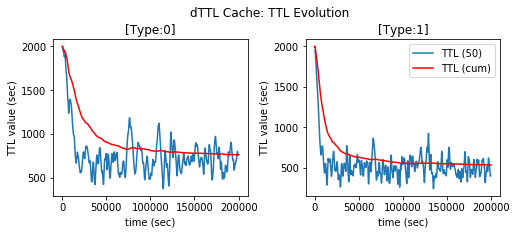

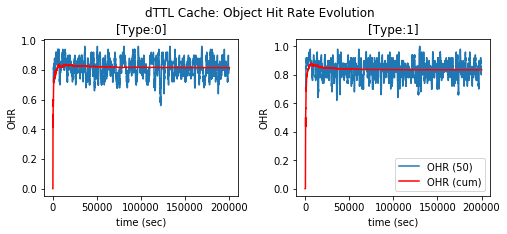

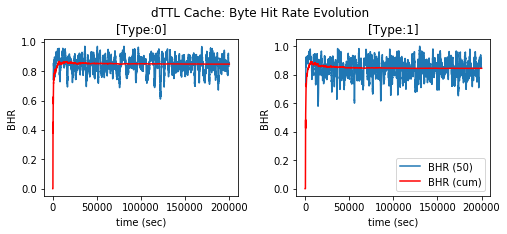

**fTTL Cache**


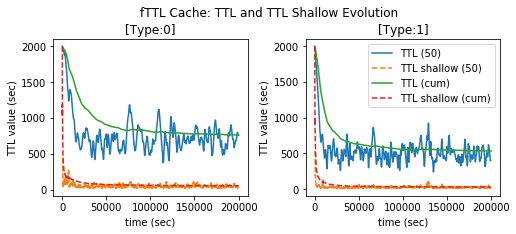

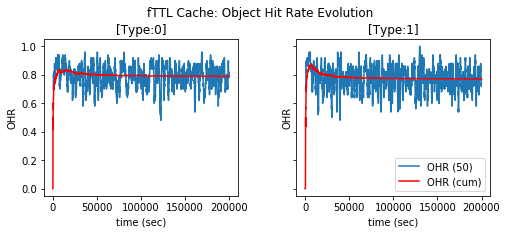

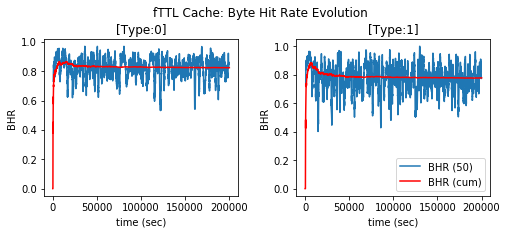

In [18]:
# MA: Moving Average filtering with window size = win.
#log_dTTL =[hit, ttl, size, typ]
#log_fTTL =[hits, ttls, size, typ]
win = 50#int(T/1e3)

time_array_tot = np.cumsum(iat)
time_array = {i: [time_array_tot[l] for l in index[i]] for i in range(num_type)}
time_array_avg = {i: moving_average(time_array[i], win) for i in range(num_type)}

# dTTL Cache
print '**dTTL Cache**'
ttl_array = {i: [log_dTTL[l][1][i] for l in index[i]] for i in range(num_type)}
ttl_array_avg = {i: moving_average_uw(ttl_array[i], win) for i in range(num_type)}
ttl_array_cum = {i: cum_average_uw(ttl_array[i]) for i in range(num_type)}

ohr_array = {i: [log_dTTL[l][0] for l in index[i]] for i in range(num_type)}
ohr_array_avg = {i: moving_average_uw(ohr_array[i], win) for i in range(num_type)}
ohr_array_cum = {i: cum_average_uw(ohr_array[i]) for i in range(num_type)}

size_array = {i: [log_dTTL[l][2] for l in index[i]] for i in range(num_type)}
bhr_array_avg = {i: moving_average(ohr_array[i], win, size_array[i]) for i in range(num_type)}
bhr_array_cum = {i: cum_average(ohr_array[i], size_array[i]) for i in range(num_type)}


#Plotting figures
#dTTL Cache
fig, axs = plt.subplots(1, num_type, figsize=(4*num_type, 3))
fig.subplots_adjust(hspace = 0.3, wspace= 0.3)
for i in range(num_type):
        axs[i].set_title('[Type:%d]'%i)
        axs[i].set_xlabel('time (sec)')
        axs[i].set_ylabel('TTL value (sec)')
        axs[i].plot(time_array_avg[i], ttl_array_avg[i], '-', time_array[i], ttl_array_cum[i], 'r-')      
axs[num_type -1].legend(['TTL (%d)'%win,  'TTL (cum)'])
fig.subplots_adjust(top = 0.85)
st = fig.suptitle('dTTL Cache: TTL Evolution')
st.set_y(1.0)
plt.show()



fig, axs = plt.subplots(1, num_type, figsize=(4*num_type, 3))
fig.subplots_adjust(hspace = 0.3, wspace= 0.3)
for i in range(num_type):
        axs[i].set_title('[Type:%d]'%i)
        axs[i].set_xlabel('time (sec)')
        axs[i].set_ylabel('OHR')
        axs[i].plot(time_array_avg[i], ohr_array_avg[i], '-')
        axs[i].plot(time_array[i], ohr_array_cum[i], 'r-')
axs[num_type-1].legend(['OHR (%d)'%win,  'OHR (cum)'])       
st = fig.suptitle('dTTL Cache: Object Hit Rate Evolution')
st.set_y(1.0)
fig.subplots_adjust(top = 0.85)
plt.show()


fig, axs = plt.subplots(1, num_type, figsize=(4*num_type, 3))
fig.subplots_adjust(hspace = 0.3, wspace= 0.3)
for i in range(num_type):
        axs[i].set_title('[Type:%d]'%i)
        axs[i].set_xlabel('time (sec)')
        axs[i].set_ylabel('BHR')
        axs[i].plot(time_array_avg[i], bhr_array_avg[i], '-')
        axs[i].plot(time_array[i], bhr_array_cum[i], 'r-')
axs[num_type-1].legend(['BHR (%d)'%win,  'BHR (cum)'])       
st = fig.suptitle('dTTL Cache: Byte Hit Rate Evolution')
st.set_y(1.0)
fig.subplots_adjust(top = 0.85)
plt.show()


#fTTL Cache
print '**fTTL Cache**'
ttl_array = {i:[log_fTTL[l][1][0][i] for l in index[i]]  for i in range(num_type)}
ttl_array_avg = {i: moving_average_uw(ttl_array[i], win) for i in range(num_type)}
ttl_array_cum = {i: cum_average_uw(ttl_array[i]) for i in range(num_type)}

ttl_s_array = {i: [log_fTTL[l][1][1][i] for l in index[i]] for i in range(num_type)}
ttl_s_array_avg = {i: moving_average_uw(ttl_s_array[i], win) for i in range(num_type)}
ttl_s_array_cum = {i: cum_average_uw(ttl_s_array[i]) for i in range(num_type)}


ohr_array = {i: [log_fTTL[l][0][0]+log_fTTL[l][0][1] for l in index[i]] for i in range(num_type)}
ohr_array_avg = {i: moving_average_uw(ohr_array[i], win) for i in range(num_type)}
ohr_array_cum = {i: cum_average_uw(ohr_array[i]) for i in range(num_type)}

size_array = {i: [log_dTTL[l][2] for l in index[i]] for i in range(num_type)}
bhr_array_avg = {i: moving_average(ohr_array[i], win, size_array[i]) for i in range(num_type)}
bhr_array_cum = {i: cum_average(ohr_array[i], size_array[i]) for i in range(num_type)}

fig, axs = plt.subplots(1, num_type, figsize=(4*num_type, 3))
fig.subplots_adjust(hspace = 0.3, wspace= 0.3)
for i in range(num_type):
        axs[i].set_title('[Type:%d]'%i)
        axs[i].set_xlabel('time (sec)')
        axs[i].set_ylabel('TTL value (sec)')
        axs[i].plot(time_array_avg[i], ttl_array_avg[i], '-', time_array_avg[i], ttl_s_array_avg[i], '--')
        axs[i].plot(time_array[i], ttl_array_cum[i], '-', time_array[i], ttl_s_array_cum[i], '--')     
axs[num_type - 1].legend(['TTL (%d)'%win, 'TTL shallow (%d)'%win, 'TTL (cum)', 'TTL shallow (cum)'])
st = fig.suptitle('fTTL Cache: TTL and TTL Shallow Evolution')
st.set_y(1.0)
fig.subplots_adjust(top = 0.85)
plt.show()


fig, axs = plt.subplots(1, num_type, figsize=(4*num_type, 3), sharey = True)
fig.subplots_adjust(hspace = 0.3, wspace= 0.3)
for i in range(num_type):
        axs[i].set_title('[Type:%d]'%i)
        axs[i].set_xlabel('time (sec)')
        axs[i].set_ylabel('OHR')
        axs[i].plot(time_array_avg[i], ohr_array_avg[i], '-')
        axs[i].plot(time_array[i], ohr_array_cum[i], 'r-')
axs[num_type-1].legend(['OHR (%d)'%win,  'OHR (cum)'])       
st = fig.suptitle('fTTL Cache: Object Hit Rate Evolution')
st.set_y(1.0)
fig.subplots_adjust(top = 0.85)
plt.show()


fig, axs = plt.subplots(1, num_type, figsize=(4*num_type, 3))
fig.subplots_adjust(hspace = 0.3, wspace= 0.3)
for i in range(num_type):
        axs[i].set_title('[Type:%d]'%i)
        axs[i].set_xlabel('time (sec)')
        axs[i].set_ylabel('BHR')
        axs[i].plot(time_array_avg[i], bhr_array_avg[i], '-')
        axs[i].plot(time_array[i], bhr_array_cum[i], 'r-')
axs[num_type-1].legend(['BHR (%d)'%win,  'BHR (cum)'])       
st = fig.suptitle('fTTL Cache: Byte Hit Rate Evolution')
st.set_y(1.0)
fig.subplots_adjust(top = 0.85)
plt.show()

### 2.  Hit Rate Curve

In [19]:
hit_targets = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
hit_dTTL = []; size_dTTL = []; hit_fTTL = []; size_fTTL = []
ttl_dTTL =[]; ttl_fTTL = [];
dTTL_frac = 0.5 # target size for fTTL in fraction of the dTTL size
isOHR = True # OHR or BHR selection
param_algo['T'] = int(2e4)
for j in range(len(hit_targets)):
    if isOHR:
        param_algo['hit_target'] = [hit_targets[j]]*params['num_type']
    else:
        param_algo['hit_target'] = None
        param_algo['bhit_target'] = [hit_targets[j]]*params['num_type']
    #---------------------------------------------    
    dTTLCache, fTTLCache, _, _,_ = simulate(seq, iat, param_algo)
    #---------------------------------------------
    print 'Target hit rate: %.2f'%hit_targets[j]
    print '------dTTL-----'
    if isOHR:
        h = dTTLCache.hit_rate_avg()
    else:
        h = dTTLCache.bhit_rate_avg()
    t = dTTLCache.get_ttl()
    print 'TTL avg: %s'%" ".join("%.3f"%x for x in t)
    print 'Hit rate: %s'%" ".join("%.3f"%x for x in h)
    s = dTTLCache.size_avg()
    print 'Avg size: %s'%" ".join("%.3f"%x for x in s)
    hit_dTTL += [h]; size_dTTL += [s]; ttl_dTTL +=[t]
    #------------------------------------------
    print '------fTTL-----'
    size_target = (s*dTTL_frac) #units
    param_algo['sr_target'] = np.divide(size_target, arrival_rate, dtype = float)
    #----
    print 'Target size: %s'%" ".join("%.3f"%x for x in size_target)
    if isOHR:
        h = fTTLCache.hit_rate_avg()
    else:
        h = fTTLCache.bhit_rate_avg()
    t = fTTLCache.get_ttl()
    print 'TTL avg: %s'%" ".join("%.3f"%x[0] for x in t)
    print 'TTL shallow avg: %s'%" ".join("%.3f"%x[1] for x in t)
    print 'Hit rate: %s'%" ".join("%.3f"%x for x in h)
    s = fTTLCache.size_avg()
    print 'Avg size: %s'%" ".join("%.3f"%x for x in s)
    hit_fTTL += [h]; size_fTTL += [s]; ttl_fTTL += [t]
    print '------------------------'

0
10000
Target hit rate: 0.40
------dTTL-----
# requests:9242.00 10758.00
# hits:4419.00 5264.00
TTL avg: 328.000 80.000
Hit rate: 0.478 0.489
total bytesec:5433993.98 5793103.24
total time:200155.21
Avg size: 27.149 28.943
------fTTL-----
Target size: 13.574 14.472
# requests:9242.00 10758.00
# hit_primary:2517.00 2852.00
# hit_shallow:488.00 522.00
# hit_shadow:1838.00 2333.00
TTL avg: 328.000 42.257
TTL shallow avg: 80.000 48.860
Hit rate: 0.325 0.314
total time:200155.21
total bytesec: primary: 2515118.63 2697030.93
total bytesec: shallow: 726404.90 732528.73
total bytesec: shadow: 4887.00 5573.00
Avg size: 16.195 17.135
------------------------
0
10000
Target hit rate: 0.50
------dTTL-----
# requests:9242.00 10758.00
# hits:5208.00 6178.00
TTL avg: 440.000 120.000
Hit rate: 0.564 0.574
total bytesec:6555579.83 6880893.22
total time:200155.21
Avg size: 32.752 34.378
------fTTL-----
Target size: 16.376 17.189
# requests:9242.00 10758.00
# hit_primary:3489.00 3961.00
# hit_shallow:54

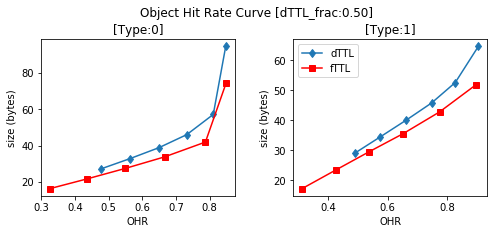

In [20]:
# Plot HRC
if isOHR:
    suptitle = 'Object Hit Rate Curve [dTTL_frac:%.2f]'%dTTL_frac
    xlabel = 'OHR'
else:
    suptitle = 'Byte Hit Rate Curve [dTTL_frac:%.2f]'%dTTL_frac
    xlabel = 'BHR'

fig, axs = plt.subplots(1, num_type, figsize=(4*num_type, 3))
fig.subplots_adjust(hspace = 0.3, wspace= 0.3)
for i in range(num_type):
        axs[i].set_title('[Type:%d]'%i)
        axs[i].set_xlabel(xlabel)
        axs[i].set_ylabel('size (bytes)')
        axs[i].plot([x[i] for x in  hit_dTTL], [y[i] for y in size_dTTL], 'd-')
        axs[i].plot([x[i] for x in  hit_fTTL], [y[i] for y in size_fTTL], 'rs-')  
axs[num_type - 1].legend(['dTTL', 'fTTL'])
st = fig.suptitle(suptitle)
st.set_y(1.0)
fig.subplots_adjust(top = 0.85)
plt.show()